### Introduction

In this project, we'll be working with a dataset taken from the Univeristy of California, Irvine's website on bike rentals in the city of Washington, D.C. Each row of the dataset contains information for a single hour, and there are 17,380 rows in total. We'll be using the data to try and predict the total number of bikes people rented in a given hour, and we'll do this with a few different machine learning models.

Information on the dataset can be found [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Let's read in the data and take a look at it.

In [1]:
import pandas as pd

rentals = pd.read_csv("bike_rental_hour.csv")
rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


<function matplotlib.pyplot.show>

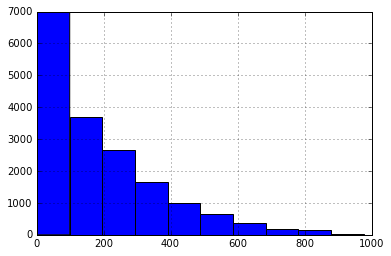

In [2]:
import matplotlib.pyplot as plt
% matplotlib inline

rentals["cnt"].hist()
plt.show

In [9]:
corrs = rentals.corr()
cnt_corrs = corrs["cnt"]
str_corrs = cnt_corrs[abs(cnt_corrs) > 0.3]
print(cnt_corrs)
str_corrs

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


hr            0.394071
temp          0.404772
atemp         0.400929
hum          -0.322911
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

### Data Discussion

The number of bike rentals in an hour seems to follow a simple geometric distribution, with between 0 and 100 bikes being rented for around 40% of the hours, and between 100 and 200 bikes for another 20% of the hours.

The features that correlate most strongly with bike rentals are the hour of day, the temperature, the "feeling temperature", the humidity, and the casual and registered users. Casual and registered users, though, while technically correlated with the number of bikes that are rented, are not causally related, but rather merely count what portion of the bikes rented are rented by causal users or registered users, so we can ignore these columns for our purposes.

Other features that might be relevant to the number of bike rentals are the year, month, and weather situation. The weather situation is recorded on a numerical ordinal scale, which means that, while the correlation value we have for the column is not ideal, as the scale itself does not indicate degrees of difference, it does still tell us that, as the weather becomes more severe (1 is clear, 4 is heavy rain, ice, snow, etc.) fewer bikes tend to be rented.

### Cleaning the Data

The main things we want to do here are remove irrelevant columns, to make data processing quicker, and alter some columns so that the information they contain is easier to deal with. We'll remove the causal and registered columns for the first reason. We'll make the information in the hours column more coarsely grained so that our models aren't overfitting to specific hours.

At present, our data is fine-grained with respect to time, but we don't need it to be this precise. Instead, we can group the hours into larger portions based on the type of activity we expect in those hours. For example, the hours between 6 and 12 are likely to be fairly similar with people travelling to work. The hours between 12 and 6pm likewise, and so on.

In [14]:
rentals = rentals.drop(["casual", "registered"], axis = 1)

def assign_label(hour):
    if hour <= 6 :
        return 4
    if hour <= 12 and hour > 6:
        return 1
    if hour <= 18 and hour > 12:
        return 2
    if hour <= 24 and hour > 18:
        return 3
    
rentals["time_label"] = rentals["hr"].apply(assign_label)
rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,4


Now we need to split our data into train and test partitions. Our dataset is currently sorted, so to make sure our train and test sets are random, we'll select our training set with the pd.sample method and then assign the rest to our test set.

To evaluate the accuracy of our models, we'll use MAE. This is because we'll be comparing the accuracy of models directly, and the cnt column measures a discrete, interval value. MAE will tell us exactly how many our predictions of the number of bikes rented are off.

In [16]:
train = rentals.sample(frac = 0.8)
test = rentals.loc[~rentals.index.isin(train.index)]

### Linear Regression Predictions

We'll start off by doing a linear regression analysis. Linear regression tends to work better when our features are linearly correlated with our target, and when the features are independent from one another.

Not all of the features in our dataset are independent (temp and atemp are directly linked, and working day is derived from holiday and weekday), but most are, and so linear regression should do fine in this regard. It's difficult to predict whether the relationship between the features and the number of rentals is linear or not, but in general it seems likely that they are.

We'll remove working day from our list of features, as the information it contains is already present in the weekday and holiday columns, but having these columns themselves will help us identify whether holidays or day of the week individually are good predictors of rental count. We'll also get rid of dteday, instant, cnt, and hr.

In [19]:
features = list(rentals)
features.remove("workingday")
features.remove("instant")
features.remove("dteday")
features.remove("cnt")
features.remove("hr")

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
lr.fit(train[features], train["cnt"])
train_pred = lr.predict(train[features])
test_pred = lr.predict(test[features])
train_mae = mean_absolute_error(train_pred, train["cnt"])
test_mae = mean_absolute_error(test_pred, test["cnt"])

In [22]:
print(train_mae, test_mae)

98.47653455346907 98.76776472139447


Perhaps unsurprisingly, the error is high. As we saw above, of the rows in the dataset, 40% had a rental count of between 0 and 100. With an MAE of almost 100, our average prediction is 100 off the actual value. As a proportion of the number of bikes that are actually being rented, this is very high.

This may be due to the fact that we've trained our model largely indiscriminately on the features in the dataset, rather than selecting specific features that are likely to be better correlated with rental count. We therefore have low bias, but high variance.

However, it is possible that a linear regression model is not the best model for our dataset. Let's now try a decision tree to see how it compares.

### Decision Tree Predictions

We'll use a decision tree to see if it does any better. The predictive accuracy of the decision tree will likely already have been helped by making the hours of our dataset more coarse-grained, which will hopefully somewhat prevent overfitting. However, overfitting is a typical issue with decision tree models, and so it is likely it will still be observed.

In [24]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(train[features], train["cnt"])
train_pred = dtr.predict(train[features])
test_pred = dtr.predict(test[features])
train_mae = mean_absolute_error(train_pred, train["cnt"])
test_mae = mean_absolute_error(test_pred, test["cnt"])

In [25]:
print(train_mae, test_mae)

3.6019324366443692 90.8487725354814


As expected, our initial model is massively overfitted to the training dataset. Despite this, however, the predictions it made on the test set are still notably better than those made by the linear regression model we used above.

We can try and reduce the overfitting of our model, and hopefully improve the accuracy of its predictions, by altering some of the parameters of the DecisionTreeRegressor class. One such parameter is min_samples_split. This sets the minimum number of rows a node should have before it can be split. Nodes with fewer rows than the specified number will not be split, but will instead form a leaf. This should reduce overfitting because rows which buck the general trend will not be isolated as their own leaves, but will instead belong to a larger leaf which, on average, exhibits the general trend. When sorting through rows to make predictions, no rows will be sorted into the leaves which represent outliers, and so the prediction for that row will be based instead on the general trend for similar rows, rather than on the value for the outlier.

In [34]:
def run_dtr(train, test, features, min_samples):
    dtr = DecisionTreeRegressor(min_samples_split = min_samples)
    dtr.fit(train[features], train["cnt"])
    train_pred = dtr.predict(train[features])
    test_pred = dtr.predict(test[features])
    train_mae = mean_absolute_error(train_pred, train["cnt"])
    test_mae = mean_absolute_error(test_pred, test["cnt"])
    train_maes.append(train_mae)
    test_maes.append(test_mae)
    return

In [35]:
min_samples = [2, 5, 10, 20, 30, 50]

train_maes = []
test_maes = []

for sample in min_samples:
    run_dtr(train, test, features, sample)

In [36]:
maes = zip(train_maes, test_maes)
list(maes)

[(3.6019324366443692, 90.39058304564634),
 (25.964863698482343, 87.22039221327195),
 (42.33290982076496, 82.85458518274974),
 (54.45779192115858, 78.98491481687815),
 (59.74605218335536, 77.67801230766959),
 (65.96717536981632, 77.94002648723084)]

We can see that as we increase the min_samples_split parameter, the error for the model decreases, and the degree of overfitting is also reduced. For our final min_samples_split value of 50, we had fairly similar errors for our training predictions and test predictions, indicating less overfitting (although the model is undoubtedly still overfit).

### Random Forest Predictions

One of the best ways to reduce the overfitting we've observed in both of our above models is with a random forest.

A random forest is an ensemble of decision trees (an ensemble being a collection of items which are considered or analyzed together). That is, our random forest consists of many different decision tree models. When we use a random forest to make a prediction, we make a prediction using every decision tree model in the ensemble, and from this set of predictions, we average or aggregate the result in some way to make our final prediction.

A random forest is good for reducing overfitting because it better hones in on the signal that is our predicted value. Every decision tree in the random forest will be slightly different and will pick up on small changes in the data differently. Some of the decision trees will handle these small changes well, and they will inform their predictions positively. Others, however, will handle them poorly, and they'll lead a decline in their predictive accuracy. With a full forest of decision trees, the goal is to average out the negative effects, and single in on the prediction that will be the most accurate.

Let's see how using a random forest affects our predictions.

In [41]:
from sklearn.ensemble import RandomForestRegressor

def run_rfr(train, test, features, trees, min_samples):
    rfr = RandomForestRegressor(n_estimators = trees, min_samples_split = min_samples)
    rfr.fit(train[features], train["cnt"])
    train_pred = rfr.predict(train[features])
    test_pred = rfr.predict(test[features])
    train_mae = mean_absolute_error(train_pred, train["cnt"])
    test_mae = mean_absolute_error(test_pred, test["cnt"])
    train_maes.append(train_mae)
    test_maes.append(test_mae)
    return

In [48]:
min_samples = [2, 5, 10, 20, 30, 50]
trees = [5, 10, 20, 50]

from itertools import product

combs = product(min_samples, trees)
combinations = []
for item in combs:
    item = list(item)
    combinations.append(item)
    
train_maes = []
test_maes = []

for combination in combinations:
    run_rfr(train, test, features, trees = combination[1], min_samples = combination[0])

In [50]:
results = zip(train_maes, test_maes)
list(results)

[(31.218573963139164, 75.94314882550643),
 (29.946315235409138, 72.93257387391091),
 (28.46469367836564, 72.50561854987488),
 (27.68218342755968, 71.63924947942353),
 (40.42029560687621, 75.3874596085413),
 (38.03311036901594, 73.72057541973753),
 (37.08240106425498, 72.11592754455779),
 (36.57857908825514, 71.33318389982274),
 (49.61464813618825, 74.10688073153048),
 (48.388736802026415, 73.37843383739323),
 (47.65327947862221, 72.77107398861084),
 (46.90474343159617, 72.19323753217468),
 (58.52539535950215, 74.70423456263148),
 (57.53207043764489, 73.3847998772585),
 (56.700288027029174, 72.85136015096366),
 (56.44686445656547, 72.82539909498456),
 (62.781429327605075, 74.81360472547642),
 (62.03415594984014, 74.74313889248326),
 (61.48527277884559, 73.59387678643792),
 (61.37852102273559, 73.65527087524136),
 (67.68992837777816, 75.80529894683475),
 (66.80397806715311, 75.38404689142702),
 (66.65101443640637, 75.0259237213836),
 (66.55025429465441, 74.83333077854465)]

### Conclusion

In all cases for our random forest, as we increased the number of trees, our predictions got more accurate. However, the most accurate model with regards to test MAE was that which used min_samples = 5, and trees = 50. After this point, as min_samples increased, the accuracy of the test MAE decreased.

Again, however, we should note that as min_samples increased, the difference between the training and test MAEs decreased, indicating that as min_samples increased overfitting also decreased.

In all cases, however, if we compare our random forest predictions with those of our decision tree predictions, the predictions of the random forest models are better.